# Exercise Sheet 04: Knowledge Tracing

**Introduction to Data Mining WS23/24**  
**Bielefeld University**  
**Alina Deriyeva, Benjamin Paaßen**  
**Exercise Sheet Publication Date: 2023-12-04**  
**Exercise Sheet Submission Deadline: 2023-12-15, noon (i.e. 12:00), via **moodle** (please do not use e-mail submissions anymore).

**NOTE** The use of language models/AI tools is permitted IF you notify us of the use (just indicate it in the respective task) and are still able to understand and present your results. We also appreciate it if you link to a chatlog of the interaction with the language model/AI tool so that we can understand better how students tend to use these tools.

**PLEASE INDICATE ALL AUTHORS OF THE SUBMISSION IN THIS FIELD**

### Preamble: Data set

Consider the data set in `sheet04_data.csv`. This data set contains the exercise results for a population of fictional students and two skills.

Each row corresponds to one attempt of one student on an exercise. The first column indicates the student index $i$, the second column the time $t$, the third column the exercise index $j$, the fourth whether this exercise needs the first skill (0 if no, 1 if yes), the fifth column whether this exercise needs the second skill (0 if no, 1 if yes), and the sixth column the outcome of the attempt: 0 for a failure, 1 for a success.

The following code loads the raw data and prints it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('sheet04_data.csv', skiprows=1, delimiter='\t', dtype=int)
print(X.shape)

(81, 6)


In the remainder of this sheet, we will apply three different knowledge tracing methods to this data:
* Performance Factors Analysis
* Bayesian Knowledge Tracing
* Deep Knowledge Tracing

### Task 04.01

Just by considering the data set itself, which of the three knowledge tracing methods might fit best? Provide a reasoning for your answer.

**ANSWER:**

Since there is not a lot of data and since some tasks require both skills I think Performance Factor Analysis, which allows multiple skills per task, probably performs best.

### Task 04.02

Let's assume that some local government wants to use a deep knowledge tracing model on this data to estimate the skill development of students to make funding decisions. In particular, school funding should be allocated to the schools that achieve a fastest skill development of students according to the model (conversely, funding should be reduced for schools that achieve less fast skill development).

Which problems do you see with this kind of approach? Please list at least two and explain them.

**ANSWER:**
I see mainly two ethical problems with this approach. Firstly, it can be very difficult to interpret how deep networks actually reach their conclusions. The reasoning for allocating funds should be well explained to ensure fairness. Secondly, it seems to me that schools which already achieve good results are less in need of funding compared to schools which achieve worse results. In a fair society funding should probably go to those more in need, rather than those already performing well.

## Performance Factors analysis


Recall the form of a performance factors analysis model: The logit-probability that student $i$ achieves a success at time step $t$, given all their previous successes and failures, is modelled as

\begin{equation}
\sum_{k \in \mathcal{K}_{i, t}} \gamma_k \cdot s_{i, k, t} + \rho_k \cdot f_{i, k, t} + \beta_k
\end{equation}

where $\mathcal{K}_{i, t}$ is the set of skills needed for the exercise student $i$ attempts at time step $t$, where $s_{i, k, t}$ is the number of past successes of student $i$ on skill $k$ before time step $t$, where $f_{i, k, t}$ is the number of past failures of student $i$ on skill $k$ before time step $t$, and where $\gamma_k$, $\rho_k$, and $\beta_k$ are the parameters of the model.

Note that this is, essentially, a logistic regression model, where $s_{i, k, t}$ and $f_{i, k, t}$ are the features and $x_{i, t}$ is the target to be predicted.


### Task 04.03

Convert the data set into a feature matrix `Xlogreg` for a logistic [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model, where each row corresponds to one attempt of one student $i$ on an exercise (just as in the raw data) and where the columns are $s_{i, 1, t}$, $f_{i, 1, t}$, 1, $s_{i, 2, t}$, $f_{i, 2, t}$, and 1 again, meaning the past successes and the past failures for the first and the second skill for student $i$ at time $t$.

HOWEVER make sure to set the first three columns to zero in every row where the exercise that student $i$ attempts at time $t$ does not involve the first skill and the last three columns to zero in every row where the exercise does not involve the second skill.

**HINT:** Look again at the lecture slides for an example of this process. While this task is not hard to program, per se, the devil is in the details.

In [3]:
Xlogreg = np.zeros((len(X), 6))
student_ids = np.unique(X.T[0])
student_successes_fails = np.zeros((len(student_ids), 4))

for i, row in enumerate(X):
    student_id = row[0]
    performance = row[5]
    requires_task_one = row[3]
    requires_task_two = row[4]
    if requires_task_one:
        Xlogreg[i][0] = student_successes_fails[student_id][0]
        Xlogreg[i][1] = student_successes_fails[student_id][1]
        Xlogreg[i][2] = 1
        if performance:
            student_successes_fails[student_id][0] += 1
        else:
            student_successes_fails[student_id][1] += 1

    if requires_task_two:
        Xlogreg[i][3] = student_successes_fails[student_id][2]
        Xlogreg[i][4] = student_successes_fails[student_id][3]
        Xlogreg[i][5] = 1
        if performance:
            student_successes_fails[student_id][2] += 1
        else:
            student_successes_fails[student_id][3] += 1
print(Xlogreg)

[[0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 2. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 3. 1. 0. 0. 0.]
 [0. 4. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [1. 4. 1. 1. 2. 1.]
 [2. 4. 1. 0. 0. 0.]
 [3. 4. 1. 2. 2. 1.]
 [0. 0. 0. 3. 2. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 2. 1. 1.]
 [0. 0. 0. 3. 1. 1.]
 [1. 0. 1. 4. 1. 1.]
 [0. 0. 0. 5. 1. 1.]
 [0. 0. 0. 6. 1. 1.]
 [2. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 2. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 2. 1.]
 [1. 1. 1. 1. 3. 1.]
 [2. 1. 1. 2. 3. 1.]
 [3. 1. 1. 0. 0. 0.]
 [4. 1. 1. 0. 0. 0.]
 [5. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 2. 1.]
 [0. 2. 1. 0. 3. 1.]
 [0. 0. 0. 1. 3. 1.]
 [0. 0. 0. 1. 4. 1.]
 [0. 0. 0. 1. 5. 1.]
 [1. 2. 1. 2. 5. 1.]
 [2. 2. 1. 0. 0. 0.]
 [3. 2. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0.]
 [0. 2. 1. 0. 2. 1.]
 [0. 3. 1. 0. 0. 0.]
 [0. 0. 0. 0. 3. 1.]
 [1. 3. 1. 0.

4### Task 04.045
Use the matrix `Xlogreg` from Task 04.03 and the last column of `X` (as targets) to train an [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with `penalty = 'l2'`, `fit_intercept = False`, and `C = 1.0`.

Report the accuracy of the model by printing the output of the `score` function of the model.

In [4]:
from sklearn.linear_model import LogisticRegression

Ylogreg = X.T[5]
model = LogisticRegression(penalty="l2", C=1.0, fit_intercept=False)
model.fit(Xlogreg, Ylogreg)
model.score(Xlogreg, Ylogreg)

0.7901234567901234

### Task 04.05

Print the trained parameters of the model in the following format:

```
gamma_1 = %g
rho_1   = %g
beta_1  = %g
gamma_2 = %g
rho_2   = %g
beta_2  = %g
```

Given these parameters, compute the amount of first skill for a student with 3 past successes and 1 past failure and print it.

In [5]:
params = {"gamma_1": model.coef_[0][0],
          "rho_1": model.coef_[0][1],
          "beta_1": model.coef_[0][2],
          "gamma_2": model.coef_[0][3],
          "rho_2": model.coef_[0][4],
          "beta_2": model.coef_[0][5]
          }

for key in params:
    print(f"{key:<10} = {params[key]:<20}")

first_skill_3_1 = 3 * params["gamma_1"] + params["rho_1"] + params["beta_1"]
print(f"Skill of student with 3 successes and 1 fail: {first_skill_3_1}")


gamma_1    = 1.4361726043604608  
rho_1      = 0.47437563468856897 
beta_1     = -0.9248912442407404 
gamma_2    = 0.9518063052576939  
rho_2      = 0.25445922161509554 
beta_2     = -1.1780902977229828 
Skill of student with 3 successes and 1 fail: 3.8580022035292103


### Task 04.06

For each student in the data set, provide a plot with time on the x axis and the predicted success probability of the performance factors analysis model on the y axis.

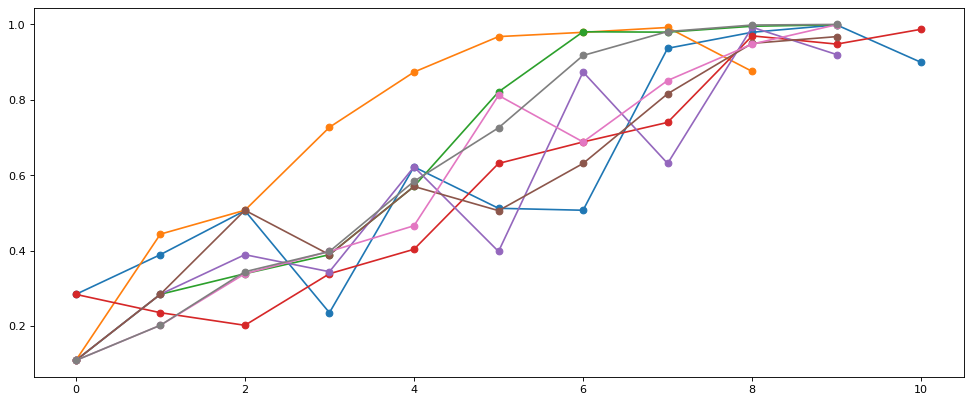

In [6]:
max_time = len(np.unique(X.T[1]))
success_probabilities = np.zeros((len(student_ids), max_time))

predictions = model.predict_proba(Xlogreg).T[1]
for i, prediction in enumerate(predictions):
    stud_id = X[i][0]
    time = X[i][1]
    success_probabilities[stud_id][time] = prediction
plt.figure(figsize=(15, 6), dpi=80)
for student_prob in success_probabilities:
    x, y = [], []
    for i, prob in enumerate(student_prob):
        if prob != 0:
            y.append(prob)
            x.append(i)
    plt.plot(x, y, marker="o")


### Task 04.07

In the previous task, you probably noticed that the predicted success probability of the performance factors analysis model sometimes drops for later timesteps. Explain this finding.

**ANSWER:**  This is probably either due to earlier failures when the student performed worse than expected or, in most cases probably, the fact that later tasks might require different skills. A student might have a .9 probability of success for tasks of skill 1 at time step 8 but at time step 9 skill 2 is required for which the student only has a .3 probability of success.

### Task 04.08 (Bonus Task)

Extend the performance factors analysis model with exercise difficulty parameters and fit it to the data. Print the accuracy and the parameters. How did this change influence the accuracy compared to the model in Task 04.04?

In [7]:
num_exercises = len(np.unique(X.T[2]))

Xlogreg_tasks = np.pad(Xlogreg, ((0,0),(num_exercises, 0)), mode='constant', constant_values=0)

for i, row in enumerate(X):
    exercise = row[2]
    Xlogreg_tasks[i][exercise] = 1

model_with_tasks = LogisticRegression(penalty="l2", C=1.0, fit_intercept=False)
model.fit(Xlogreg_tasks, Ylogreg)
model.score(Xlogreg_tasks, Ylogreg)

0.8765432098765432

**ANSWER:** The model performs much better! Accuracy is increased by ~8%

## Bayesian Knowledge Tracing

A Bayesian Knowledge Tracing Model is a two-state Hidden Markov Model (either a student mastered a skill at time $t$ or they did not), where we denote the random variable for the state of student $i$ at time $t$ as $Z_{i, t}$ and the random variable for the result (pass/fail) of student $i$ at time $t$ as $X_{i, t}$. The parameters of the model are:

\begin{align*}
p_{Z_{i, 1}}(1) &= p_\mathrm{start},\\
p_{X_{i, t}|Z_{i, t}}(0|1) &= p_\mathrm{slip}, \\
p_{X_{i, t}|Z_{i, t}}(1|0) &= p_\mathrm{guess}, \\
p_{Z_{i, t}|Z_{i, t-1}}(1|1) &= 1, &\text{ and} \\
p_{Z_{i, t}|Z_{i, t-1}}(1|0) &= p_\mathrm{trans}
\end{align*}

Given a series of past results $x_{i, 1}, \ldots, x_{i, t}$ for student $i$, we denote:

\begin{align}
p_{i, t+1} &= p_{Z_{i, t+1}|X_{i, t}, \ldots, X_{i, 1}}(1|x_{i, t}, \ldots, x_{i, 1}) & \text{ and} \\
q_{i, t}   &= p_{Z_{i, t}|X_{i, t}, \ldots, X_{i, 1}}(1|x_{i, t}, \ldots, x_{i, 1})
\end{align}

With these two short-hand notations, we obtain the following equations (refer to the lecture slides for the derivation):
\begin{align}
p_{i, t+1} &= q_{i, t} + p_\mathrm{trans} \cdot (1 - q_{i, t}) \\
q_{i, t}   &=
\begin{cases}
\frac{(1-p_\mathrm{slip}) \cdot p_{i, t}}{(1-p_\mathrm{slip}) \cdot p_{i, t} + p_\mathrm{guess} \cdot (1 - p_{i, t})} & \text{if } x_{i, t} = 1 \\
\frac{p_\mathrm{slip} \cdot p_{i, t}}{p_\mathrm{slip} \cdot p_{i, t} + (1-p_\mathrm{guess}) \cdot (1 - p_{i, t})} & \text{if } x_{i, t} = 0
\end{cases}
\end{align}

### Task 04.09

Let's assume we have a series of results $x_{i, 1}, \ldots, x_{i, t}$ for student $i$ with the last entry being $x_{i, t} = 1$.

Further, let's denote the joint probability $p_{Z_{i, t}, X_{i, t}, \ldots, X_{i, 1}}(z, x_{i, t}, \ldots, x_{i, 1})$ as $\alpha_{i, t}(z)$.

Show, that the following equality holds:
\begin{equation*}
\alpha_{i, t}(1) = (1 - p_\mathrm{slip}) \cdot \Big[p_\mathrm{trans} \cdot \alpha_{i, t-1}(0) + \alpha_{i, t-1}(1)\Big]
\end{equation*}

**HINT**: Recall that, in a BKT model, the latent space $Z_{i, t}$ of student $i$ at time $t$ is conditionally independent of all past observations given $Z_{i, t-1}$ and $X_{i, t}$ is conditionally independent from past observations given $Z_{i, t}$.

Other than these bits of information, you 'only' need to smartly apply the definition of conditional probabilities and the law of total probability for this task. 

**ANSWER:**


\begin{align*}

\end{align*}


### Task 04.10

Given the equations above, write a Python function that takes an array $x_{i, 1}, \ldots, x_{i, t}$ of student results (pass/fail) for one skill and the parameters $p_\mathrm{start}$, $p_\mathrm{slip}$, $p_\mathrm{guess}$, and $p_\mathrm{trans}$ as input and returns an array of probability $p_{i, 1+1}, \ldots, p_{i, t+1}$ as output.

In [31]:
def bkt(results, p_start, p_slip, p_guess, p_trans):
    p_i_ts = np.zeros(len(results) + 1)
    p_i_ts[0] = p_start

    for t, x_i_t in enumerate(results):
        p_i_t = p_i_ts[t]
        if x_i_t == 1:
            numerator = (1-p_slip)*p_i_t
            denominator = (1-p_slip)*p_i_t + p_guess*(1-p_i_t)
            q_i_t = numerator / denominator
        elif x_i_t == 0:
            numerator = p_slip * p_i_t
            denominator = p_slip*p_i_t + (1-p_guess)*(1-p_i_t)
            q_i_t = numerator / denominator
        else:
            raise ValueError("x_i_t must be 0 or 1")

        p_i_ts[t+1] = q_i_t + p_trans*(1-q_i_t)
    return p_i_ts[1:]


### Task 04.11

For this task, use the parameter settings $p_\mathrm{start} = 0.1$, $p_\mathrm{slip} = 0.1$, $p_\mathrm{guess} = 0.2$, and $p_\mathrm{trans} = 0.3$.

For each student and each skill, provide a plot with time step $t$ on the x axis and $p_{i, t+1}$ on the y axis, using your function from Task 04.10.

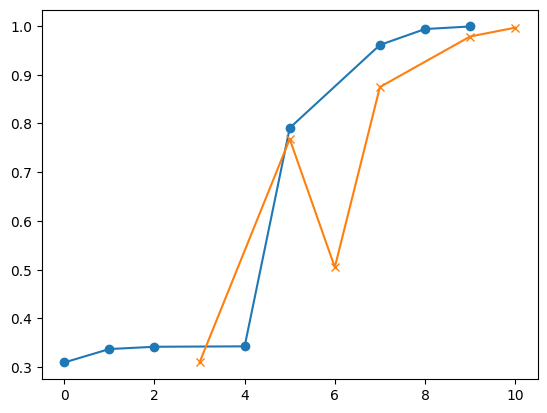

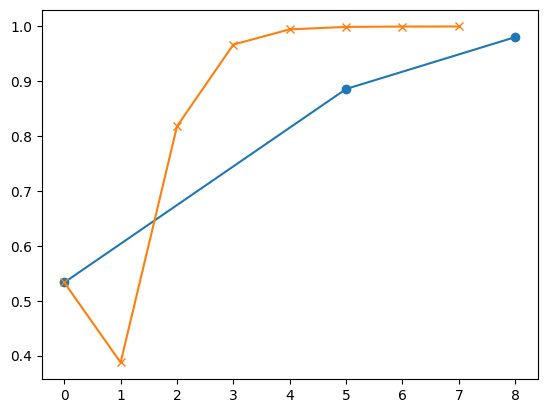

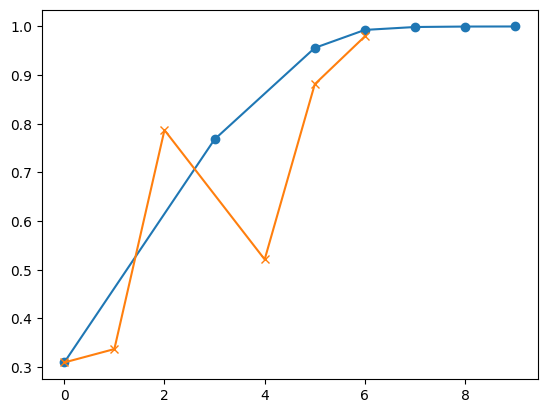

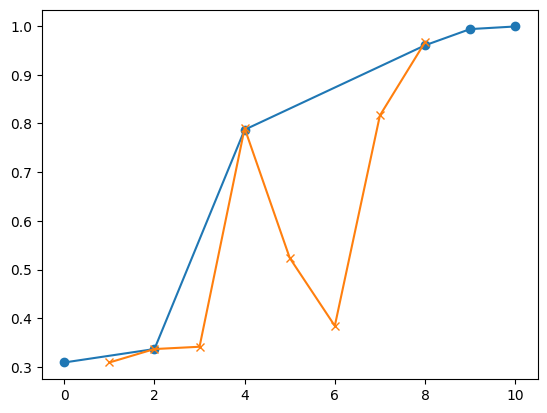

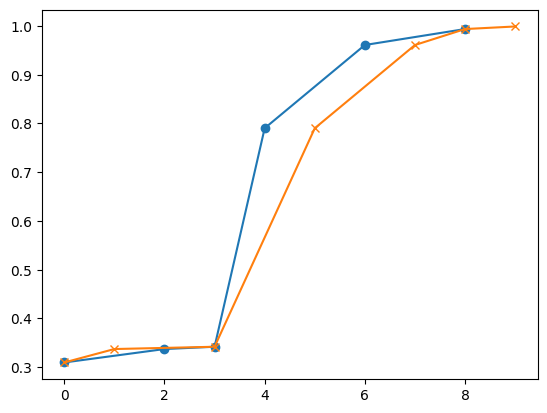

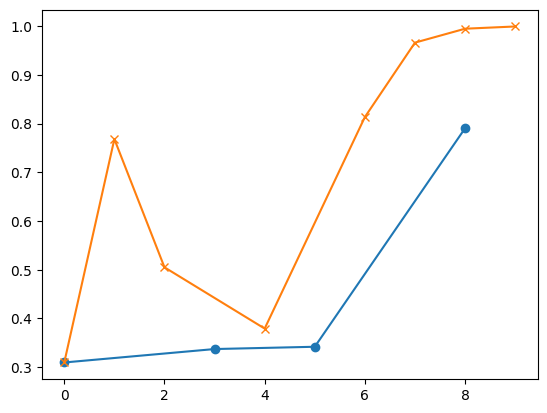

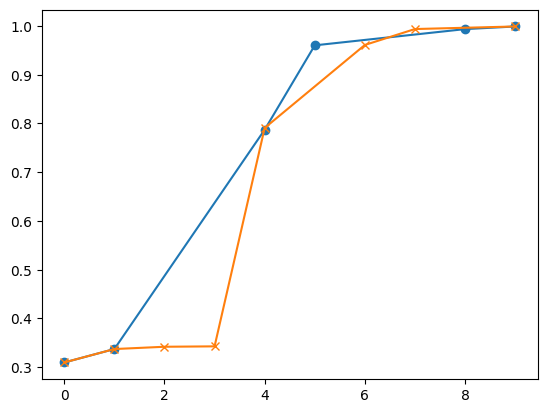

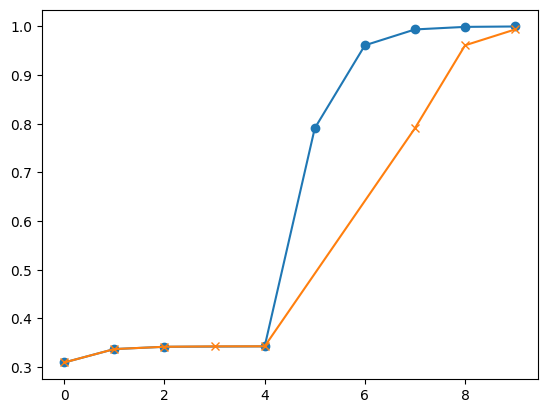

In [35]:
p_start = 0.1
p_slip = 0.1
p_guess = 0.2
p_trans = 0.3

student_skill_results = []

for student_id in student_ids:
    rows = X[X.T[0] == student_id]
    skill_one = rows[rows.T[3] == 1]
    skill_two = rows[rows.T[4] == 1]
    x_one = skill_one.T[1]
    x_two = skill_two.T[1]
    y_one = bkt(skill_one.T[5], p_start, p_slip, p_guess, p_trans)
    y_two = bkt(skill_two.T[5], p_start, p_slip, p_guess, p_trans)
    student_skill_results.append((x_one, y_one))
    student_skill_results.append((x_two, y_two))
    plt.plot(x_one, y_one, marker="o")
    plt.plot(x_two, y_two, marker="x")
    plt.show()


For each of the parameters, test what happens if you increase the parameter by 0.1. Report the effect on $p_{i, t+1}$.

In [43]:
param_pairs = [
    (p_start+0.1, p_slip, p_guess, p_trans),
    (p_start, p_slip+0.1, p_guess, p_trans),
    (p_start, p_slip, p_guess+0.1, p_trans),
    (p_start, p_slip, p_guess, p_trans+0.1),
]
student_skill_results = []

param_map = {0: "p_start", 1: "p_slip", 2: "p_guess", 3: "p_trans"}
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
for i, (new_start, new_slip, new_guess, new_trans) in enumerate(param_pairs):
    effect_skill_one = []
    effect_skill_two = []
    for student_id in student_ids:
        rows = X[X.T[0] == student_id]
        skill_one = rows[rows.T[3] == 1]
        skill_two = rows[rows.T[4] == 1]
        y_one_final_skill = bkt(skill_one.T[5], p_start, p_slip, p_guess, p_trans)[-1]
        y_two_final_skill = bkt(skill_two.T[5], p_start, p_slip, p_guess, p_trans)[-1]
        y_one_final_skill_new = bkt(skill_one.T[5], new_start, new_slip, new_guess, new_trans)[-1]
        y_two_final_skill_new = bkt(skill_two.T[5], new_start, new_slip, new_guess, new_trans)[-1]
        effect_skill_one.append(y_one_final_skill-y_one_final_skill_new)
        effect_skill_two.append(y_two_final_skill-y_two_final_skill_new)
    print(f"Increasing {param_map[i]} by 0.1")
    print(f"Differences Skill One:\n {np.asarray(effect_skill_one)}")
    print(f"Differences Skill Two:\n {np.asarray(effect_skill_two)}")

Increasing p_start by 0.1
Differences Skill One:
 [-2.29e-07 -8.13e-03 -1.21e-06 -7.44e-06 -8.21e-06 -2.23e-04 -7.44e-06
 -3.57e-08]
Differences Skill Two:
 [-8.60e-05 -3.64e-06 -8.65e-05 -7.43e-06 -1.29e-06 -6.20e-06 -2.29e-07
 -2.60e-07]
Increasing p_slip by 0.1
Differences Skill One:
 [ 2.77e-04  6.45e-03  2.45e-05  3.69e-04  1.02e-03 -1.34e-02  3.69e-04
  6.75e-05]
Differences Skill Two:
 [-1.33e-04  1.20e-05 -4.35e-03 -8.26e-03  3.02e-04  2.87e-05  2.77e-04
  8.28e-04]
Increasing p_guess by 0.1
Differences Skill One:
 [0.   0.03 0.   0.   0.01 0.06 0.   0.  ]
Differences Skill Two:
 [0.01 0.   0.03 0.03 0.   0.   0.   0.01]
Increasing p_trans by 0.1
Differences Skill One:
 [-6.40e-04 -8.47e-03 -1.98e-05 -6.49e-04 -3.73e-03 -8.37e-02 -6.49e-04
 -1.07e-04]
Differences Skill Two:
 [-2.22e-03 -1.47e-05 -1.22e-02 -1.88e-02 -6.41e-04 -5.76e-04 -6.40e-04
 -3.73e-03]


**ANSWER**
The effects are really miniscule, the model seems very robust to parameter changes, especially after a lot of time has passed.

## Deep Knowledge Tracing

### Task 04.13

Generate a list `Xs_dkt` of matrices, one per student.

The matrix `Xi` for student $i$ should start with one row of zeros and each subsequent row `Xi[t+1, :]` of the matrix should correspond to one attempt of student $i$ at some exercise at time $t$. There should be two columns per exercise (twelve columns overall), where entry `Xi[t+1, j]` should be 1 if the attempt $t$ was successful and `Xi[t+1, 6 + j]` should be 1 if the attempt was a failure. The last attempt of the student should not be represented in `Xi`.

For example, if student $i$ has three attempts, one success on exercise 0, one failure on exercise 2, and a success on exercise 2, then the matrix `Xi` should be as follows:

```
Xi = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # zero row for the first attempt
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # first attempt (success at first exercise)
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]  # second attempt (failure at third exercise)
]
```

Generate a list `Ys_dkt` of matrices, one per student, which contain the exercise indices and the results results of the student.

For example, if student $i$ has three attempts, one success on exercise 0, one failure on exercise 2, and a success on exercise 2, then `Yi` should be as follows:

```
Yi = [
    [0, 1],
    [2, 0],
    [2, 1]
]
```

In [80]:
import torch

num_exercises = 6
Xis = []
for student_id in student_ids:
    X_i = np.zeros((max_time, num_exercises*2))
    for t, row in enumerate(X[X.T[0] == student_id][:-1]):
        success = row[5]
        exercise_id = row[2]
        attempt_idx = exercise_id if success == 1 else exercise_id+6
        X_i[t+1, attempt_idx] = 1
    Xis.append(torch.from_numpy(X_i).float())


### Task 04.14

The following deep knowledge tracing model takes a student matrix `Xi` from Task 04.13 as input and produces a matrix `Logits` with as many rows and 6 columns, one per exercise. The entry `Logits[t, j]` is supposed to be the logit probability of student $i$ succeeding at exercise $j$ in time step $t$.

To train this model, we want to use the following scheme:

Repeat for num_epochs:
1. Pick a random student $i$.
2. Get the matrix `Xi` and the array `Yi` from Task 04.11.
3. Compute the output `Logits` for input `Xi` via the `forward` method of the DKT modul.
4. For each time step $t$, repeat:
    1. Retrieve the exercise index `j = Yi[t, 0]` and the actual result `x = Yi[t, 1]`.
    2. Use the function `torch.nn.functional.binary_crossentropy_with_logits` to compute the loss between the predicted logit probability `Logits[t, j]` and the actual outcome `x`.

Implement this scheme in the `fit` function of the model below.

In [129]:
import torch
import random


class DKT(torch.nn.Module):
    """The initialization function of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    num_exercises: int
        The number of exercises in the data set.
    num_neurons: int (default = 32)
        The number of neurons used in the GRU.
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set.
    learning_rate: float (default = 1E-2)

    """

    def __init__(self, num_exercises, num_neurons=32, C=1000., num_epochs=1000, learning_rate=1E-2):
        super(DKT, self).__init__()
        self.num_exercises_ = num_exercises
        self.num_neurons_ = num_neurons
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate
        # initialize the network layers
        self.gru_ = torch.nn.GRU(self.num_exercises_ * 2, self.num_neurons_)
        self.out_ = torch.nn.Linear(self.num_neurons_, self.num_exercises_)

    """Predicts logit probabilities of success for the given input data
    
    Parameters
    ----------
    X: torch.tensor
        A feature matrix for one student, where each row represents one attempted exercise.
        The first self.num_exercises_ columns should indicate whether a student achieved
        a success at exercise j in this timestep, the latter self.num_exercises_ columns
        should indicate failures.

    Returns
    -------
    Logits: torch.tensor
        A matrix where the entry Logits[t, j] indicates the predicted logit success probability
        for the student for exercise j at time t.

    """

    def forward(self, X):
        H, _ = self.gru_(X)
        return self.out_(H)

    """Scores the accuracy of this model.
    
    Parameters
    ----------
    X: list
        A list of feature matrices, one per student.
    Y: list
        A list of target matrices, one per student.

    Returns
    -------
    acc: float
        An accuracy value.
    
    """

    def score(self, X, Y):
        num_attempts = 0
        num_successes = 0
        for i in range(len(X)):
            Logits = self.forward(X[i])
            for t in range(Y[i].shape[0]):
                num_attempts += 1
                j = int(Y[i][t, 0])
                if Y[i][t, 1] > 0.5 and Logits[t, j] > 0:
                    num_successes += 1
                elif Y[i][t, 1] < 0.5 and Logits[t, j] <= 0:
                    num_successes += 1
        return num_successes / num_attempts

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: list
        A list of feature matrices, one per student.
    Y: list
        A list of target matrices, one per student.

    """

    def fit(self, X, Y):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1. / self.C_)

        for epoch in range(self.num_epochs_):
            i = random.randint(0, len(student_ids)-1)

            X_i = X[i]
            Y_i = Y[i]

            logits = self.forward(X_i)
            epoch_loss = 0
            for t, (j, result) in enumerate(Y_i):
                optimizer.zero_grad()
                prediction = logits[t, j.int()]

                epoch_loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction, result)
                #epoch_loss += loss
            epoch_loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch+1} sum of losses: {epoch_loss}")

### Task 04.15

Train the model on the data using your `fit` function from Task 04.14 and report the accuracy using the `score` function.

In [130]:
model = DKT(num_exercises)
Y = []
for student_id in student_ids:
    Y.append(torch.from_numpy(X[X.T[0] == student_id][:, [2, 5]]).float())

model.fit(Xis, Y)

Epoch 2 sum of losses: 0.628204882144928
Epoch 100 sum of losses: 0.0026708904188126326
Epoch 200 sum of losses: 0.0015961299650371075
Epoch 300 sum of losses: 0.00586645258590579
Epoch 400 sum of losses: 0.000959412835072726
Epoch 500 sum of losses: 0.0014129426563158631
Epoch 600 sum of losses: 0.0023648173082619905
Epoch 700 sum of losses: 0.0012877037515863776
Epoch 800 sum of losses: 0.0011880489764735103
Epoch 900 sum of losses: 0.0014851979212835431
Epoch 1000 sum of losses: 0.0018743580440059304
